In [1]:
%load_ext autoreload

# Traces simulator v2

In [2]:
%autoreload
from tracer.simulator import TraceSimulator

sim = TraceSimulator(
    number_towers=500,
    number_users=1,
    number_cycles=24,
    expander=1,
    sigma=0.005,
    vel_friction=0.9,
#     method='distance_square',
#     verbose=True,
)

## Generate random user traces

In [3]:
sim.generate()

## Plot generated results

### Towers positions

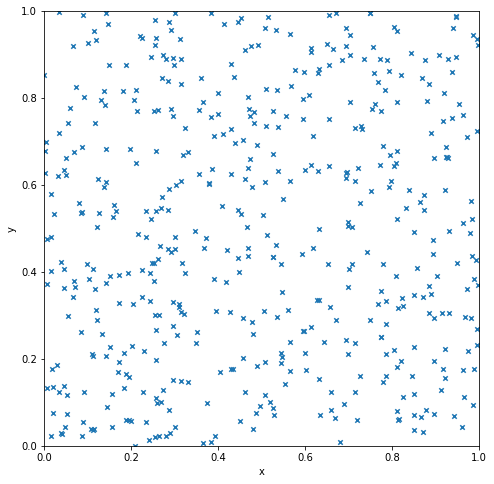

In [6]:
sim.plot_towers(annotate_towers=False);

### User trace

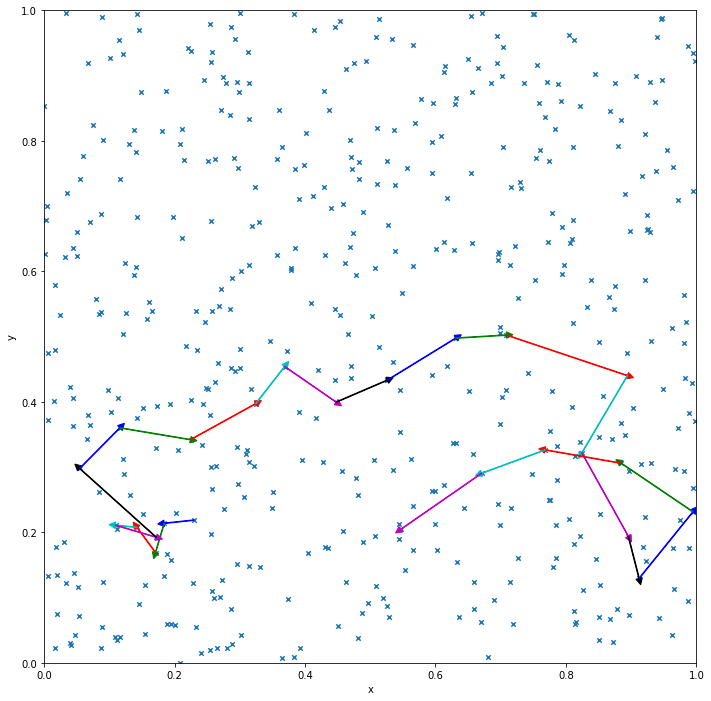

In [5]:
sim.plot_user_trace(user_id=0, annotate_towers=False)